Visualização inicial:


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Distribuição da variável alvo:
diagnosis
B    357
M    212
Name: count, dtype: int64
Avaliando modelo: Logistic Regression


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

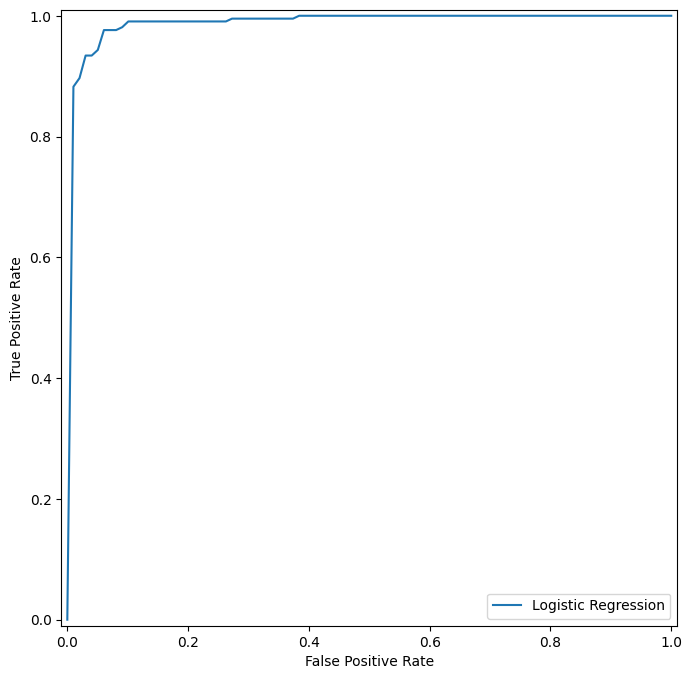

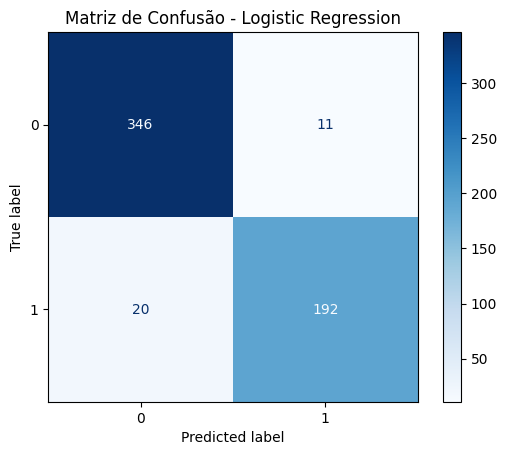

Avaliando modelo: Random Forest


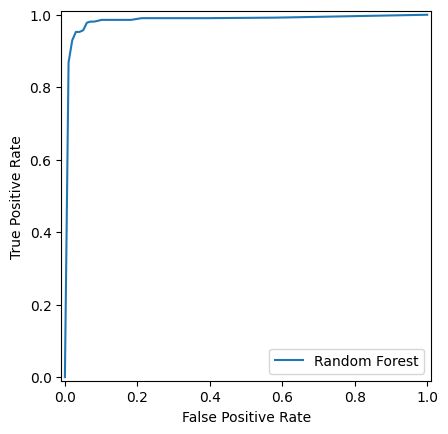

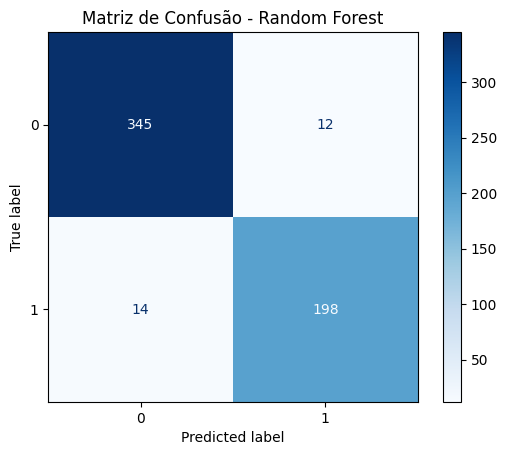

Avaliando modelo: SVM


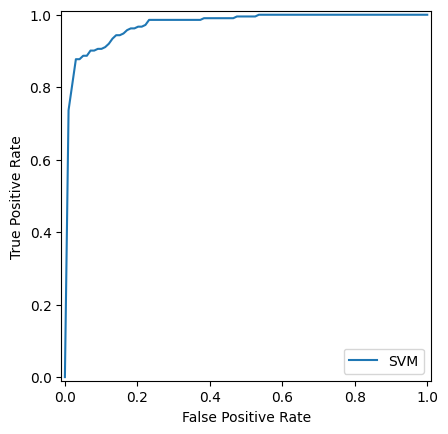

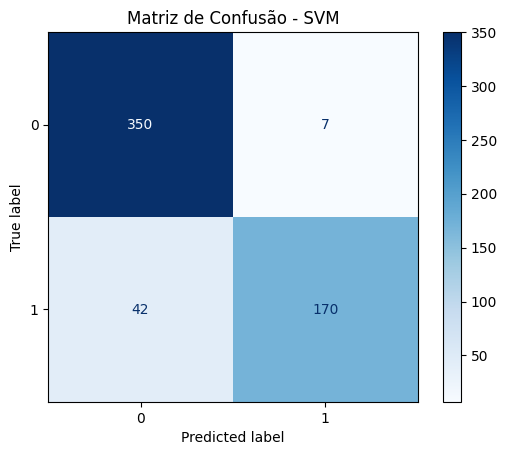

Avaliando modelo: KNN


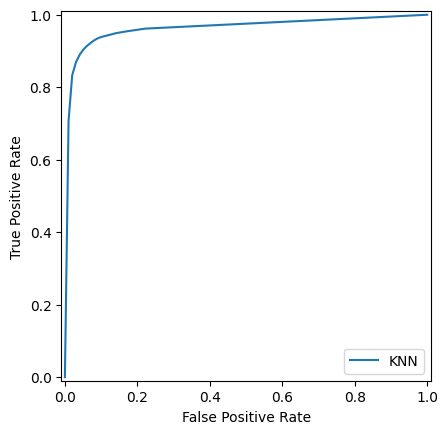

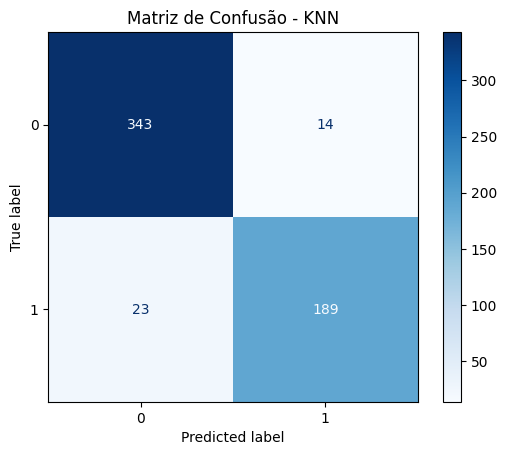

Avaliando modelo: Naive Bayes


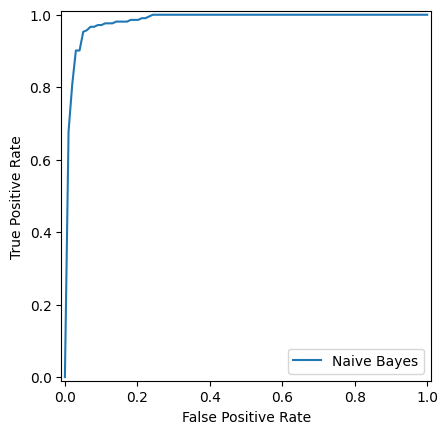

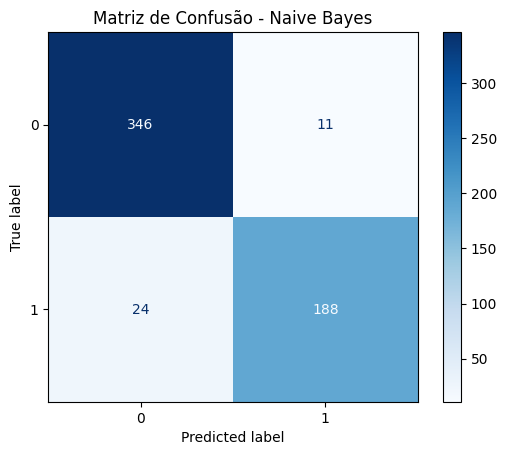

Avaliando modelo: Gradient Boosting


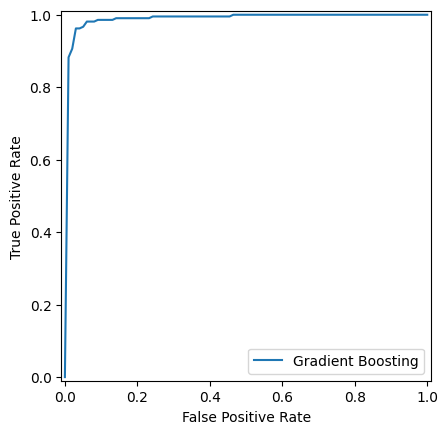

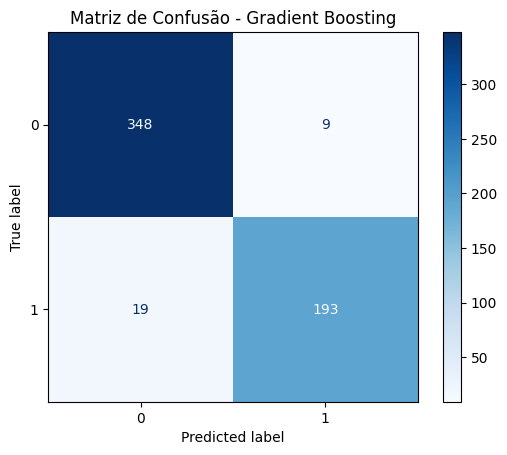

/tmp/ipython-input-1388917602.py:150: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


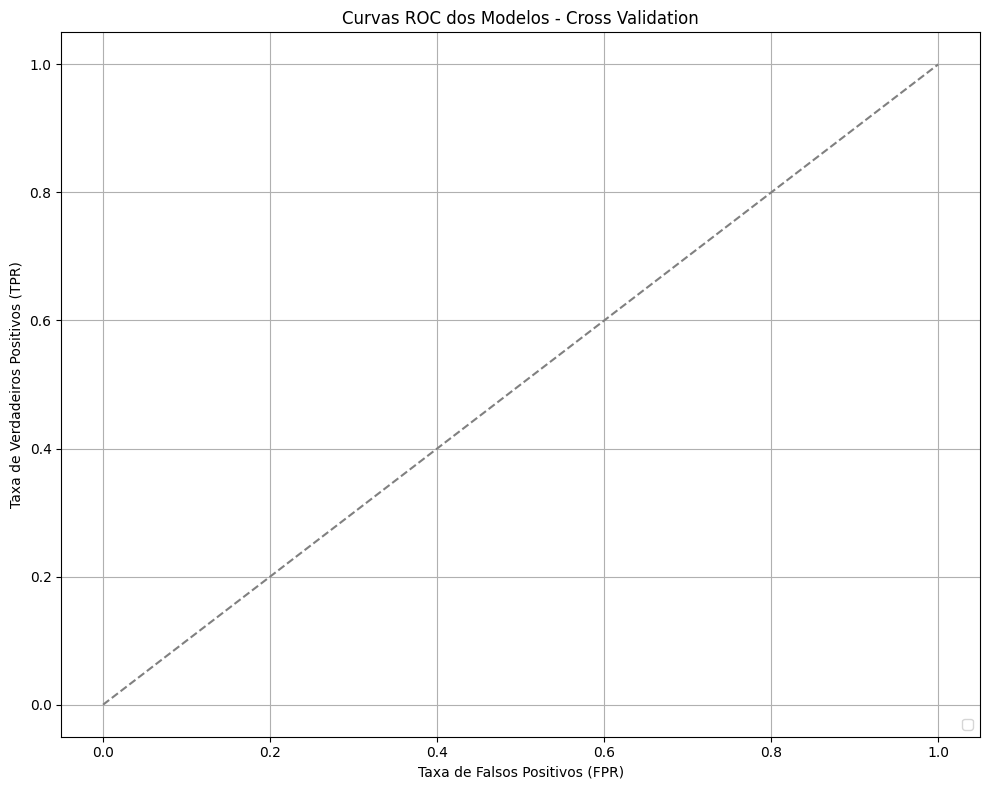

In [7]:
# 1. Importação de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# 2. Carregamento dos dados

df = pd.read_csv("data.csv")

# Remover colunas desnecessárias
df = df.drop(columns=["id"], errors="ignore")
df = df.drop(columns=["Unnamed: 32"], errors="ignore")

print("Visualização inicial:")
display(df.head())

print("\nDistribuição da variável alvo:")
print(df["diagnosis"].value_counts())


# 3. Pré-processamento

df["diagnosis"] = df["diagnosis"].map({"M":1, "B":0})

X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 4. Definição de funções

def treinar_modelo(modelo, nome):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = None
    if hasattr(modelo, "predict_proba"):
        y_prob = modelo.predict_proba(X_test)[:, 1]

    return {
        "Modelo": nome,
        "Acurácia": accuracy_score(y_test, y_pred),
        "Precisão": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan,
        "Pred": y_pred,
        "Prob": y_prob
    }



# 5. Treinamento dos modelos

modelos = [
    (LogisticRegression(max_iter=1000), "Logistic Regression"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (SVC(probability=True, random_state=42), "SVM"),
    (KNeighborsClassifier(n_neighbors=5), "KNN"),
    (GaussianNB(), "Naive Bayes"),
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting")
]


# ====== Cross-Validation + Curva ROC + Matriz de Confusão ======
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(10, 8))

for model, name in modelos:
    print(f"Avaliando modelo: {name}")

    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    # Para armazenar predições de todas as dobras
    y_true_all = []
    y_pred_all = []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinamento do modelo
        model.fit(X_train, y_train)

        # Probabilidades previstas (para ROC)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)

        # Predições finais (para matriz de confusão)
        y_pred = model.predict(X_test)

        # Guarda os valores verdadeiros e previstos
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

        # Calcula a curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    # ===== Curva ROC Média =====
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    RocCurveDisplay(fpr=mean_fpr, tpr=mean_tpr, estimator_name=name).plot(ax=plt.gca())

    # ===== Matriz de Confusão (com base em todas as dobras) =====
    cm = confusion_matrix(y_true_all, y_pred_all)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusão - {name}")
    plt.show()

# Linha de referência (classificação aleatória)
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curvas ROC dos Modelos - Cross Validation")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



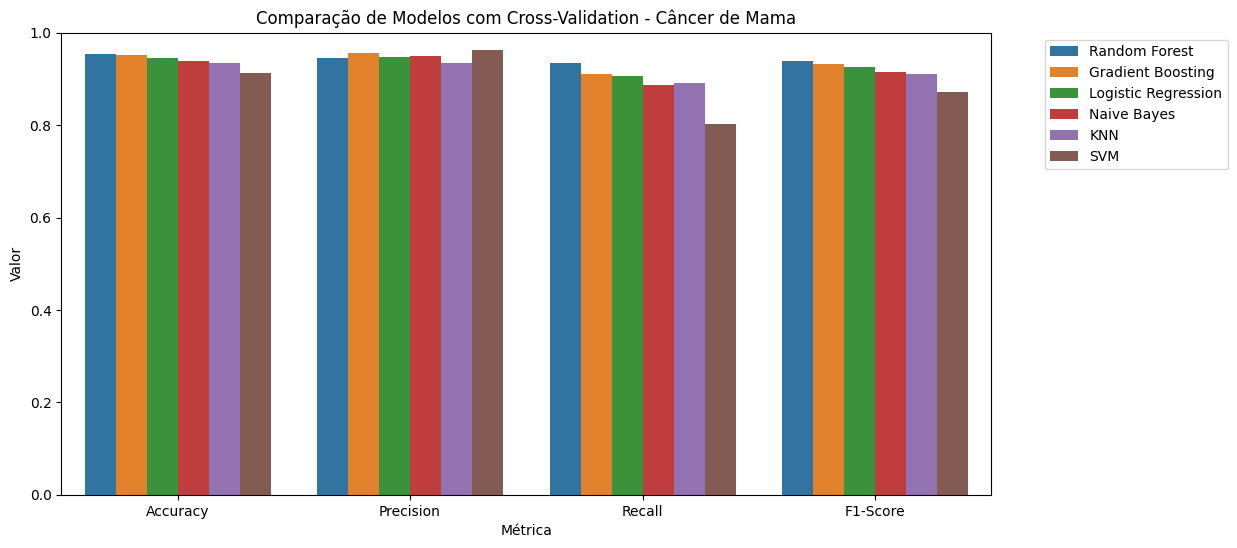

,Etapa,Descrição
0,Tabela de métricas (CV),Mostra a performance média de cada modelo após...
1,Gráfico comparativo (CV),Permite comparar visualmente qual modelo é mai...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

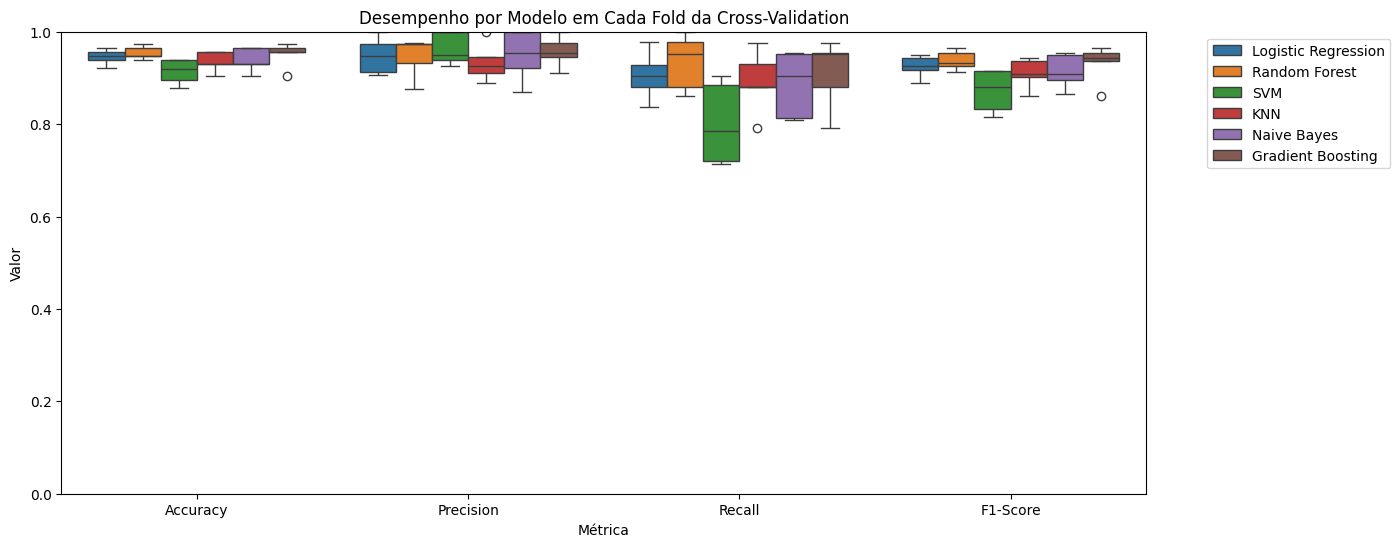

,Etapa,Descrição
0,Boxplot de desempenho em cada fold,Mostra a variação das métricas em cada fold da...


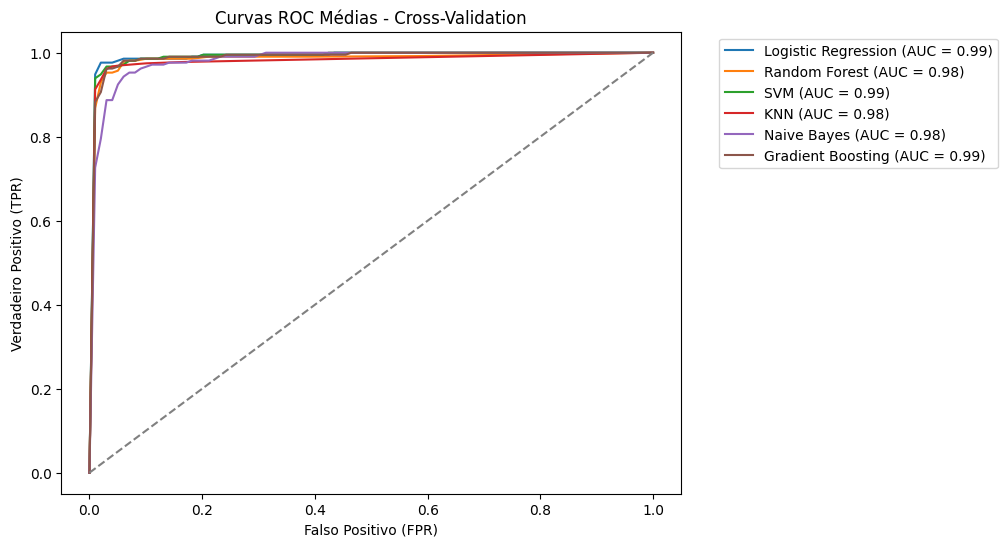

,Etapa,Descrição
0,Curvas ROC (CV),As curvas ROC são calculadas em cada fold e de...


In [ ]:
# 6. Comparação entre modelos (baseada na cross-validation)

metricas = ["Accuracy", "Precision", "Recall", "F1-Score"]

df_plot = results_df.reset_index().melt(
    id_vars="index", value_vars=metricas,
    var_name="Métrica", value_name="Valor"
)
df_plot = df_plot.rename(columns={"index": "Modelo"})

plt.figure(figsize=(12,6))
sns.barplot(data=df_plot, x="Métrica", y="Valor", hue="Modelo")
plt.title("Comparação de Modelos com Cross-Validation - Câncer de Mama")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

interpretação_resultados_cv = pd.DataFrame({
    "Etapa": ["Tabela de métricas (CV)", "Gráfico comparativo (CV)"],
    "Descrição": [
        "Mostra a performance média de cada modelo após 5 folds de cross-validation.",
        "Permite comparar visualmente qual modelo é mais consistente em cada métrica."
    ]
})
display(interpretação_resultados_cv)


# 6.1 Gráfico de desempenho detalhado em cada fold (boxplot)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for model, name in modelos:
    scores = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1'])
    for i in range(5):
        cv_scores.append({
            'Modelo': name,
            'Fold': i+1,
            'Accuracy': scores['test_accuracy'][i],
            'Precision': scores['test_precision'][i],
            'Recall': scores['test_recall'][i],
            'F1-Score': scores['test_f1'][i]
        })

df_cv_scores = pd.DataFrame(cv_scores)

plt.figure(figsize=(14,6))
sns.boxplot(data=df_cv_scores.melt(id_vars=['Modelo','Fold'], var_name='Métrica', value_name='Valor'),
            x='Métrica', y='Valor', hue='Modelo')
plt.title('Desempenho por Modelo em Cada Fold da Cross-Validation')
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

interpretação_folds = pd.DataFrame({
    "Etapa": ["Boxplot de desempenho em cada fold"],
    "Descrição": [
        "Mostra a variação das métricas em cada fold da validação cruzada, permitindo avaliar a estabilidade dos modelos."
    ]
})
display(interpretação_folds)


# 7. Curvas ROC médias (baseadas na cross-validation)

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for model, name in modelos:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_idx, test_idx in cv.split(X, y):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_cv = scaler.fit_transform(X_train_cv)
        X_test_cv = scaler.transform(X_test_cv)

        model.fit(X_train_cv, y_train_cv)
        if hasattr(model, "predict_proba"):
            y_prob_cv = model.predict_proba(X_test_cv)[:, 1]
        else:
            from sklearn.preprocessing import LabelBinarizer
            y_prob_cv = model.decision_function(X_test_cv)
            y_prob_cv = (y_prob_cv - y_prob_cv.min()) / (y_prob_cv.max() - y_prob_cv.min())

        fpr, tpr, _ = roc_curve(y_test_cv, y_prob_cv)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, label=f"{name} (AUC = {mean_auc:.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.title("Curvas ROC Médias - Cross-Validation")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

interpretação_roc_cv = pd.DataFrame({
    "Etapa": ["Curvas ROC (CV)"],
    "Descrição": [
        "As curvas ROC são calculadas em cada fold e depois médias, mostrando a robustez dos modelos em prever casos malignos vs benignos."
    ]
})
display(interpretação_roc_cv)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

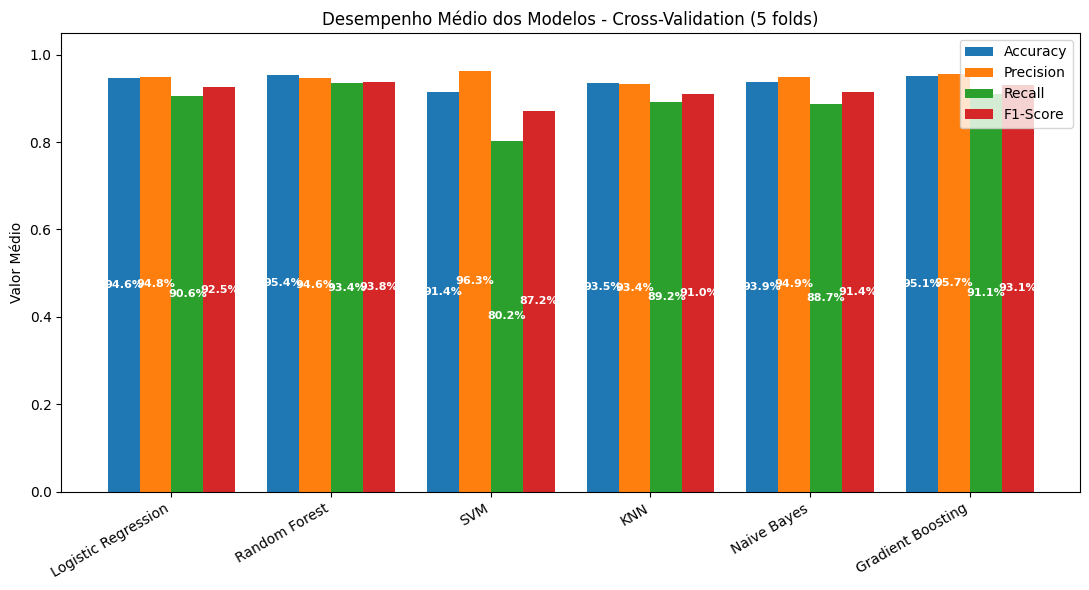

,Etapa,Descrição
0,Gráfico de barras - desempenho médio (CV) com ...,"Mostra as métricas médias (Accuracy, Precision..."


In [ ]:
# 6.1 Gráfico de desempenho mais intuitivo (cross-validation com porcentagens internas)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for model, name in modelos:
    scores = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1'])
    cv_scores.append({
        'Modelo': name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1-Score': scores['test_f1'].mean()
    })

df_cv_scores = pd.DataFrame(cv_scores)

# Plotagem com porcentagens internas
plt.figure(figsize=(11,6))
x = np.arange(len(df_cv_scores['Modelo']))
largura = 0.2

# Criação das barras
bars_acc = plt.bar(x - largura*1.5, df_cv_scores['Accuracy'], width=largura, label='Accuracy')
bars_pre = plt.bar(x - largura/2, df_cv_scores['Precision'], width=largura, label='Precision')
bars_rec = plt.bar(x + largura/2, df_cv_scores['Recall'], width=largura, label='Recall')
bars_f1  = plt.bar(x + largura*1.5, df_cv_scores['F1-Score'], width=largura, label='F1-Score')

# Adicionar porcentagens dentro das barras
def adicionar_rotulos(barras):
    for bar in barras:
        altura = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            altura / 2,  # posição vertical central
            f"{altura*100:.1f}%",  # exibe uma casa decimal
            ha='center', va='center', color='white', fontsize=8, fontweight='bold'
        )

adicionar_rotulos(bars_acc)
adicionar_rotulos(bars_pre)
adicionar_rotulos(bars_rec)
adicionar_rotulos(bars_f1)

# Estética do gráfico
plt.xticks(x, df_cv_scores['Modelo'], rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.ylabel('Valor Médio')
plt.title('Desempenho Médio dos Modelos - Cross-Validation (5 folds)')
plt.legend()
plt.tight_layout()
plt.show()

interpretação_desempenho_cv = pd.DataFrame({
    "Etapa": ["Gráfico de barras - desempenho médio (CV) com porcentagens internas"],
    "Descrição": [
        "Mostra as métricas médias (Accuracy, Precision, Recall, F1-Score) de cada modelo com base na cross-validation, exibindo as porcentagens dentro das barras para melhor legibilidade."
    ]
})
display(interpretação_desempenho_cv)

